In [1]:
# Install causalml and other dependencies
!pip install causalml dowhy xgboost shap matplotlib seaborn scikit-learn pandas numpy dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 

# Data Description and Project Overview

The dataset used in this assignment is the **Hillstrom MineThatData E-Mail Analytics and Data Mining Challenge** dataset. And this dataset was originally published by Kevin Hillstrom on his MineThatData blog, and this dataset contains information on 64,000 customers who were randomly assigned to receive one of two email campaigns ("Mens E-Mail" or "Womens E-Mail") or no email (control group).

### What the Dataset Contains:
- **Customer Attributes:**  
  - **Recency:** This indicates the number of months since the last purchase.
  - **History:** This indicates the actual dollar amount spent in the past year.
  - **Mens/Womens:** This indicates the binary indicators of whether the customer purchased mens or womens merchandise.
  - **Newbie:** This indicates whether the customer is new.
  - Additional fields such as `history_segment`, `zip_code`, `channel`, etc.

- **Email Campaign Information:**  
  - **Segment:** This specifies which email (if any) the customer received (e.g., "Mens E-Mail", "Womens E-Mail", or "No E-Mail").

- **Outcome Variables:**  
  - **Visit, Conversion, Spend:** These are the variables that capture customer behavior during the two weeks following the email campaign. For this assignment, the **conversion** indicator (a binary value where 1 indicates a purchase) is used as the target outcome.

### How the Dataset is Used in this Assignment:
- **Alignment with Assignment Goals:**  
  This dataset is ideal for causal inference because the treatment assignment (which email is received) is randomized. And this allows us to estimate the causal effect of receiving a "Mens E-Mail" on conversion rates, and hence thereby addressing the assignment's objective to understand how a causal effect can be estimated using modern tools.

- **Data Preparation:**  
  In our analysis, we first look at into how we can normalize the column names and then filter the data to include only those customers who received the "Mens E-Mail" (treatment group) and those who received no email (control group). We then go ahead to create a binary treatment variable accordingly.

- **Causal Inference Analysis:**  
  We use two approaches:
  1. **CausalML Meta-Learners:**  
     - *LRSRegressor* (an S-learner using linear regression)  
     - *XGBTRegressor* (a T-learner using XGBoost)  
     For both methods we here would estimate the Average Treatment Effect (ATE) of receiving the "Mens E-Mail" on the conversion rate.
     
  2. **DoWhy Analysis:**  
     We then take this into account to construct a causal model using DoWhy by specifying the treatment, outcome, and a set of common causes (e.g., recency, history, mens, womens, newbie). You will see that the DoWhy analysis includes visualizing the causal graph, identifying the estimand using the back-door criterion, and also estimating the causal effect, and performing a placebo treatment refutation to test the robustness of the effect.



# Causal Inference Assignment Using Hillstrom Dataset

In the code block that follows we will:
- Load and preprocess the dataset (from http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv)
- Define the target (conversion), treatment (comparing "mens e-mail" vs. "no e-mail"), and common causes
- Then we experiment with two causal meta-learners: LRSRegressor and XGBTRegressor
- we go ahead to plot feature importance for one learner
- Then we build a causal model using DoWhy, view the causal graph, identify the effect, estimate the effect, and refute the estimate
- And finally, we then conclude with our hypothesis and interpretation of the outcomes.


Dataset columns:
 ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend']
First few rows:
   recency history_segment  history  mens  womens   zip_code  newbie channel  \
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone   
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web   
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web   
3        9  5) $500 - $750   675.83     1       0      Rural       1     Web   
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web   

         segment  visit  conversion  spend  
0  Womens E-Mail      0           0    0.0  
1      No E-Mail      0           0    0.0  
2  Womens E-Mail      0           0    0.0  
3    Mens E-Mail      0           0    0.0  
4  Womens E-Mail      0           0    0.0  

Treatment group distribution:
treatment
1    21307
0    21306
Name: count, dty

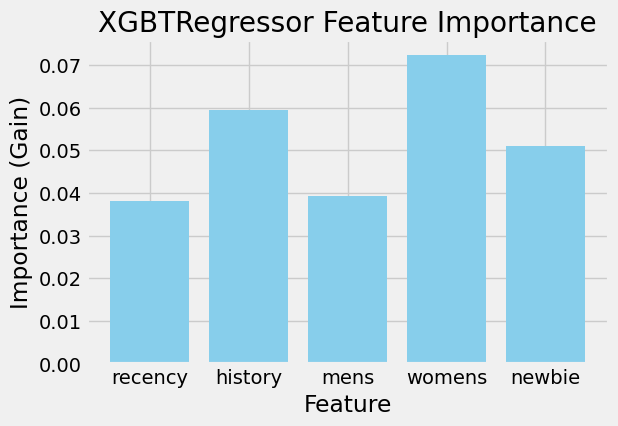

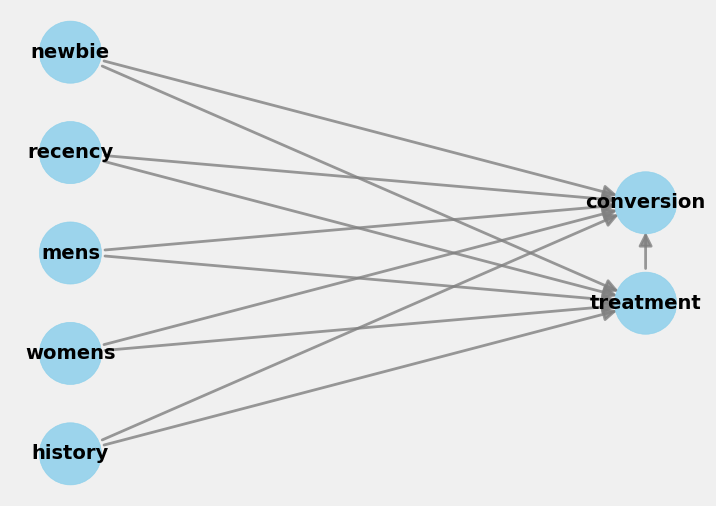


Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(E[conversion|history,womens,mens,recency,newbie])
d[treatment]                                                  
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→conversion then P(conversion|treatment,history,womens,mens,recency,newbie,U) = P(conversion|treatment,history,womens,mens,recency,newbie)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Causal Effect Estimate using DoWhy (Linear Regression):
Effect = 0.006791382188457271

Refutation result:
Refute: Use a Placebo Treatment
Estimated effect:0.006791382188457271
New effect:0.00012921815870043987
p value:0.8400000000000001



In [2]:
"""
## 1. Import Libraries
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Import causalml learners
from causalml.inference.meta import LRSRegressor, XGBTRegressor

# Import DoWhy and IPython display for images (if needed)
from dowhy import CausalModel
from IPython.display import Image


"""
## 2. Load and Preprocess the Hillstrom Dataset

The dataset is available at:
http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv

We normalize the column names (strip whitespace and convert to lowercase) so that we can reliably access columns.
For this analysis, we compare the "Mens E-Mail" treatment group with the "No E-Mail" (control) group.
"""

# Load the dataset
url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
df = pd.read_csv(url)

# Normalize column names: remove extra whitespace and convert to lowercase.
df.columns = df.columns.str.strip().str.lower()

print("Dataset columns:\n", df.columns.tolist())
print("First few rows:")
print(df.head())


# Filter dataset: keep rows where 'segment' is either "Mens E-Mail" or "No E-Mail"
df_subset = df[df["segment"].isin(["Mens E-Mail", "No E-Mail"])].copy()

# Create a binary treatment indicator:
# treatment = 1 if the customer received "Mens E-Mail", 0 if "No E-Mail"
df_subset["treatment"] = (df_subset["segment"] == "Mens E-Mail").astype(int)

# Display the treatment group distribution
print("\nTreatment group distribution:")
print(df_subset["treatment"].value_counts())


# Define outcome and common causes.
# Outcome (target): we use the "conversion" column (binary indicator)
target = "conversion"

# Common causes (features) selected from historical customer attributes.
common_features = ["recency", "history", "mens", "womens", "newbie"]

# Create X, treatment, y arrays for CausalML analysis.
X = df_subset[common_features].values
treatment = df_subset["treatment"].values
y = df_subset[target].values


"""
## 3. CausalML Analysis Using Meta-Learners

Here we will experiment with two meta-learners:
- **LRSRegressor:** an S-learner using linear regression.
- **XGBTRegressor:** a T-learner using XGBoost.

We then print the estimated Average Treatment Effect (ATE) and its confidence interval.
"""

# LRSRegressor: S-learner based on linear regression.
lr_model = LRSRegressor()
ate_lr, lb_lr, ub_lr = lr_model.estimate_ate(X, treatment, y)
print("ATE using LRSRegressor (Linear Regression S-learner):")
print("ATE =", ate_lr[0], "CI = (", lb_lr[0], ",", ub_lr[0], ")")


# XGBTRegressor: T-learner using XGBoost.
xgb_model = XGBTRegressor(random_state=42)
ate_xgb, lb_xgb, ub_xgb = xgb_model.estimate_ate(X, treatment, y)
print("\nATE using XGBTRegressor (XGBoost T-learner):")
print("ATE =", ate_xgb[0], "CI = (", lb_xgb[0], ",", ub_xgb[0], ")")


"""
### 3.1 Plotting Feature Importance

For the XGBTRegressor, we will first go ahead and extract feature importance from the underlying XGBoost model.
If we see that the internal learner is not directly accessible, we re-fit an independent XGBRegressor as a workaround.
"""

# Fit the XGBTRegressor (if not already fitted)
xgb_model.fit(X, treatment, y)

# Attempt to access the underlying model attributes.
if hasattr(xgb_model, "learner"):
    booster = xgb_model.learner.get_booster()
elif hasattr(xgb_model, "_learner"):
    booster = xgb_model._learner.get_booster()
elif hasattr(xgb_model, "learner_"):
    booster = xgb_model.learner_.get_booster()
else:
    # Workaround: re-fit an independent XGBRegressor on the same data.
    from xgboost import XGBRegressor
    temp_learner = XGBRegressor(random_state=42)
    temp_learner.fit(X, treatment, y)
    booster = temp_learner.get_booster()

# Extract feature importance using the 'gain' metric.
importance_dict = booster.get_score(importance_type='gain')
print("\nRaw feature importance (gain):", importance_dict)

# Map the feature indices (e.g., "f0", "f1") to our common_features list.
features_from_model = []
importances = []
for key, value in importance_dict.items():
    idx = int(key[1:])  # e.g., "f0" becomes 0
    if idx < len(common_features):
        features_from_model.append(common_features[idx])
        importances.append(value)

# Plot the feature importance.
plt.figure(figsize=(6,4))
plt.bar(features_from_model, importances, color="skyblue")
plt.xlabel("Feature")
plt.ylabel("Importance (Gain)")
plt.title("XGBTRegressor Feature Importance")
plt.show()


"""
## 4. Causal Inference Using DoWhy

We now build a causal model using DoWhy on the full preprocessed DataFrame (`df_subset`).

We specify:
- **Treatment:** "treatment" (0 or 1)
- **Outcome:** "conversion"
- **Common causes:** our selected features

We then:
- Visualize the causal graph.
- Identify the causal estimand.
- Estimate the causal effect using linear regression.
- Refute the estimate using a placebo treatment refuter.
"""

# Create a DoWhy CausalModel using df_subset.
model = CausalModel(
    data=df_subset,
    treatment="treatment",
    outcome="conversion",
    common_causes=common_features
)


# Visualize the assumed causal graph.
# Simply call view_model(); the graph will be displayed.
model.view_model()


# Identify the causal effect (estimand) using the back-door criterion.
identified_estimand = model.identify_effect()
print("\nIdentified estimand:")
print(identified_estimand)


# Estimate the causal effect using a linear regression method.
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nCausal Effect Estimate using DoWhy (Linear Regression):")
print("Effect =", estimate.value)


# Refute the estimate using a placebo treatment refuter.
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print("\nRefutation result:")
print(refutation)



## 5. Conclusion

**Hypothesis:**

- Receiving the "Mens E-Mail" (treatment = 1) increases the probability of conversion compared to receiving no email (treatment = 0).

**Summary of Findings:**  
- **CausalML Analysis:**  
  - LRSRegressor (Linear Regression S‐learner): Estimated ATE ≈ 0.0068, with 95% CI roughly (0.0050, 0.0086).
  - XGBTRegressor (XGBoost T‐learner): Estimated ATE ≈ 0.0067, with 95% CI roughly (0.0050, 0.0083).

  We see that both the models point to a ~0.67 percentage‐point increase in the probability of conversion attributable to the “Mens E-Mail” treatment.

- **Feature Importance:**  
  - The XGB T‐learner’s feature importance plot (based on gain) suggests that womens, history, and newbie are among the strongest predictors.
  - Although we are focusing on whether “Mens E-Mail” drives conversions, we can say that these variables appear to exert the most influence on how the model differentiates responders from non‐responders.
- **DoWhy Analysis:**  
  - Here with the use of Back‐door adjustment via Linear Regression: The DoWhy‐estimated effect (≈0.0068) we see that this aligns with the meta‐learners, and helps us in reinforcing the conclusion that the “Mens E-Mail” increases conversion rates.
  - Placebo Refutation: The placebo test found no significant effect with a “fake” (placebo) treatment, and this helps us to support our validity of the original estimate and suggesting that the measured effect is not merely an artifact of confounding or random noise.

**Interpretation:**  
- We see that all methods consistently show a positive, albeit modest, effect of the “Mens E-Mail” on conversion.
- In business terms, a 0.67 percentage‐point lift can be meaningful, if we see that the conversion yields substantial revenue or if the cost of sending emails is low.
- We also see that the top‐ranked features (e.g., whether a customer also shops for women’s items, recency of purchase, and whether they are a new customer) can be used to further refine targeting strategies.
- And finally we also recognise that while these results suggest a real causal impact, the additional tests (e.g., sensitivity analyses, different outcome definitions, or alternative causal structures) could offer further confidence in the magnitude of the effect.